In [1]:
import numpy as np

import torchvision.transforms as transforms
from torchvision.utils import make_grid

from torch.utils.data import DataLoader
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch.nn.functional as F
import torch

import os
import time
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import rcParams
from torchvision import transforms
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from skimage import exposure, filters, util

from tqdm.notebook import tqdm
import warnings
torch.cuda.empty_cache()



In [2]:
from dataset import create_loaders
data_directory = "/home/w22038792/Documents/Bern/GAN_data/"


train_loader, test_loader = create_loaders(data_directory,test_percent=0.2, batch_size=1, 
            sdo_channels=['304', '171'], iris_channel='1400')

ims = next(iter(train_loader))
print(ims['A'])
print(ims['A'].shape, ims['B'].shape)
print(max(ims['A'].shape))

tensor([[[[0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]]]])
torch.Size([1, 1, 548, 504]) torch.Size([1, 1, 471, 449])
548


In [3]:
"""# Time test for single epoch load
start = time.time()
for ir, sd,a,b in train_loader:
    pass
end = time.time()
print(np.round(end - start, 2), 'seconds for single epoch load')"""

"# Time test for single epoch load\nstart = time.time()\nfor ir, sd,a,b in train_loader:\n    pass\nend = time.time()\nprint(np.round(end - start, 2), 'seconds for single epoch load')"

tensor([0])


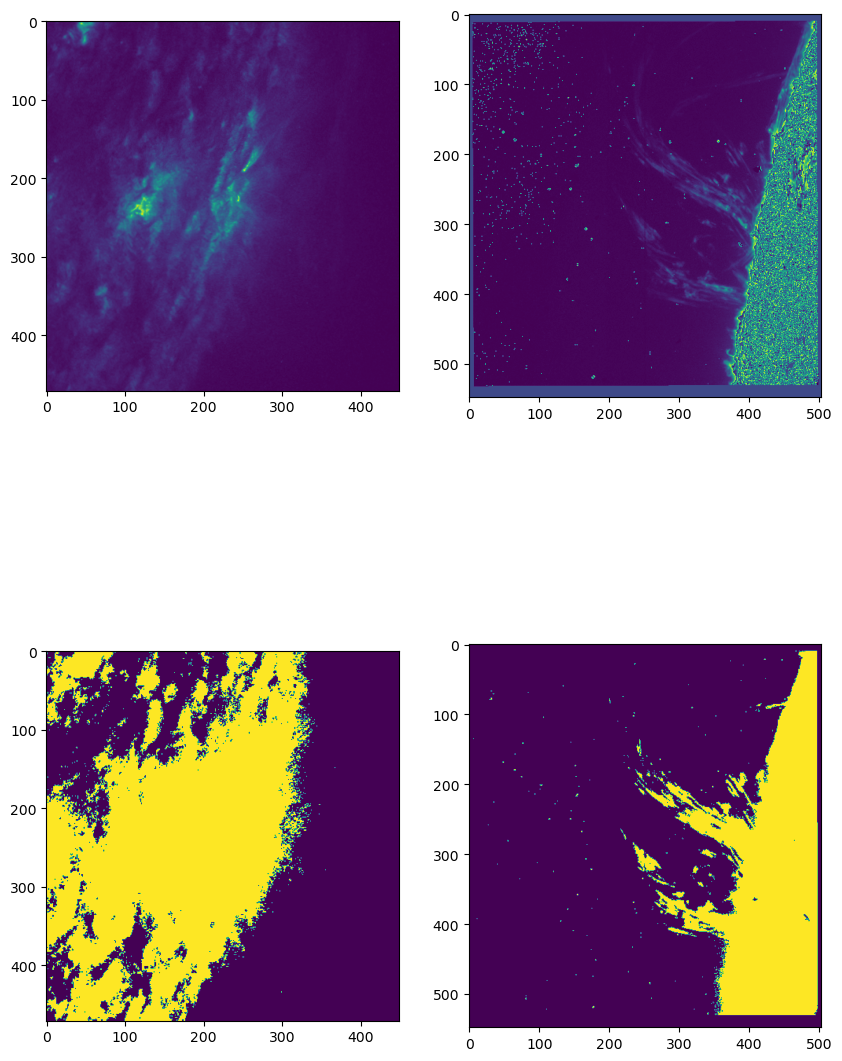

In [4]:
_, ax = plt.subplots(2, 2, figsize=(10, 15))
indices = torch.randperm(len(ims['D']))[:1]
#indices = torch.tensor([45,8,27,28])
print(indices)
for i, samples in enumerate(zip(ims['D'][indices], ims['C'][indices],ims['B'][indices], ims['A'][indices])):
    aia = (((samples[0][0]).numpy()).astype(np.uint8))
    iris = (((samples[1][0]).numpy()).astype(np.uint8))
    norm_aia = (((samples[2][0]).numpy()).astype(np.uint8))
    norm_iris = (((samples[3][0]).numpy()).astype(np.uint8))
    ax[0,0].imshow(aia)
    ax[0,1].imshow(iris)
    ax[1,0].imshow(norm_aia)
    ax[1,1].imshow(norm_iris)
plt.show()

In [5]:
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02) # reset Conv2d's weight(tensor) with Gaussian Distribution
        if hasattr(m, 'bias') and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0) # reset Conv2d's bias(tensor) with Constant(0)
        elif classname.find('BatchNorm2d') != -1:
            torch.nn.init.normal_(m.weight.data, 1.0, 0.02) # reset BatchNorm2d's weight(tensor) with Gaussian Distribution
            torch.nn.init.constant_(m.bias.data, 0.0) # reset BatchNorm2d's bias(tensor) with Constant(0)


In [7]:
def temp_weights_init_normal(m):
    classname =  m.__class__.__name__
    print(classname)

In [8]:
def DiscGen(input_shapeA,input_shapeB):
    from generator_2 import Generator

    G_AB = Generator(input_shapeA, 9)
    G_BA = Generator(input_shapeB, 9)
    
    
    

    from discriminator import NLayerDiscriminator

    D_A = NLayerDiscriminator(input_shapeA)
    D_B = NLayerDiscriminator(input_shapeB)
    
    cuda = torch.cuda.is_available()
    
    Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

    """if cuda:
        G_AB = G_AB.cuda()
        G_BA = G_BA.cuda()
        D_A = D_A.cuda()
        D_B = D_B.cuda()

        criterion_GAN.cuda()
        criterion_cycle.cuda()
        criterion_identity.cuda()"""
        
    G_AB.apply(weights_init_normal)
    G_BA.apply(weights_init_normal)
    D_A.apply(weights_init_normal)
    D_B.apply(weights_init_normal)
    
    #print("Discgen" ,G_BA)
    
    #G_AB.apply(temp_weights_init_normal)
    
    return(G_AB,G_BA,D_A,D_B)

In [9]:
def optimizer(G_AB,G_BA,D_A,D_B,lr,b1,b2):
    import itertools
    # lr = 0.0002
    # b1 = 0.5
    # b2 = 0.999

    optimizer_G = torch.optim.Adam(
        itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
    )

    optimizer_D_A = torch.optim.Adam(
        D_A.parameters(), lr=lr, betas=(b1,b2)
    )
    optimizer_D_B = torch.optim.Adam(
        D_B.parameters(), lr=lr, betas=(b1,b2)
    )
    
    return(optimizer_G,optimizer_D_A,optimizer_D_B)


In [10]:
class LambdaLR:
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert (n_epochs - decay_start_epoch) > 0, "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch
        
    def step(self, epoch):
        return 1.0 - max(0, epoch+self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

In [11]:
def lr_scheduler(optimizer_G,optimizer_D_A,optimizer_D_B):
    # n_epochs = 10
    # epoch = 0
    # decay_epoch = 5


    lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(
        optimizer_G,
        lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
    )

    lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(
        optimizer_D_A,
        lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
    )
    lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(
        optimizer_D_B,
        lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step
    )

    return(lr_scheduler_G,lr_scheduler_D_A,lr_scheduler_D_B)

In [12]:
def train():
    
    epoch = 0 # epoch to start training from
    n_epochs = 5 # number of epochs of training
    batch_size = 1 # size of the batches
    lr = 0.0002 # adam : learning rate
    b1 = 0.5 # adam : decay of first order momentum of gradient
    b2 = 0.999 # adam : decay of first order momentum of gradient
    decay_epoch = 3 # suggested default : 100 (suggested 'n_epochs' is 200)
                     # epoch from which to start lr decay
    
    for epoch in range(epoch, n_epochs):
        for i, batch in enumerate(tqdm(train_loader)):
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            # Set model input
            real_A = batch['A']#.to(device)
            real_B = batch['B']#.to(device)
            
            G_AB,G_BA,D_A,D_B = DiscGen((real_A.size(1),real_A.size(2),real_A.size(3)),(real_B.size(1),real_B.size(2),real_B.size(3)))
            
            optimizer_G,optimizer_D_A,optimizer_D_B = optimizer(G_AB,G_BA,D_A,D_B,lr,b1,b2)
            
            cuda = torch.cuda.is_available()

            Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
            

            # Adversarial ground truths
            valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.
            fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape))) # requires_grad = False. Default.

    # -----------------
    # Train Generators
    # -----------------
            G_AB.train() # train mode
            G_BA.train() # train mode

            optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
            
            print("Fake Iris Shape: ",G_BA(real_A).shape)
            print("Real Iris Shape: ",real_A.shape)
            print("Fake AIA Shape: ",G_AB(real_B).shape)
            print("Real AIA Shape: ",real_B.shape)

            # Identity Loss
            loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
            loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                                 # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
            loss_identity = (loss_id_A + loss_id_B)/2

            # GAN Loss
            fake_B = G_AB(real_A) # fake_B is fake-aia that generated by real iris
            loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
            fake_A = G_BA(real_B)
            loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'

            loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2

            # Cycle Loss
            recov_A = G_BA(fake_B) # recov_A is fake-iris that generated by fake-aia
            loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
            recov_B = G_AB(fake_A)
            loss_cycle_B = criterion_cycle(recov_B, real_B)

            loss_cycle = (loss_cycle_A + loss_cycle_B)/2

    # ------> Total Loss
            loss_G = loss_GAN + (10.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)

            loss_G.backward()
            optimizer_G.step()

    # -----------------
    # Train Discriminator A
    # -----------------
            optimizer_D_A.zero_grad()

            loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
            loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake

            loss_D_A = (loss_real + loss_fake)/2

            loss_D_A.backward()
            optimizer_D_A.step()

    # -----------------
    # Train Discriminator B
    # -----------------
            optimizer_D_B.zero_grad()

            loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
            loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake

            loss_D_B = (loss_real + loss_fake)/2

            loss_D_B.backward()
            optimizer_D_B.step()

    # ------> Total Loss
            loss_D = (loss_D_A + loss_D_B)/2

    # -----------------
    # Show Progress
    # -----------------
            if (i+1) % 50 == 0:
                sample_images()
                print('[Epoch %d/%d] [Batch %d/%d] [D loss : %f] [G loss : %f - (adv : %f, cycle : %f, identity : %f)]'
                        %(epoch+1,n_epochs,       # [Epoch -]
                          i+1,len(dataloader),   # [Batch -]
                          loss_D.item(),       # [D loss -]
                          loss_G.item(),       # [G loss -]
                          loss_GAN.item(),     # [adv -]
                          loss_cycle.item(),   # [cycle -]
                          loss_identity.item(),# [identity -]
                         ))

In [13]:
train()

  0%|          | 0/1884 [00:00<?, ?it/s]

/home/w22038792/anaconda3/envs/sol/lib/python3.8/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343962757/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Fake Iris Shape:  torch.Size([1, 1, 388, 188])
Real Iris Shape:  torch.Size([1, 1, 388, 186])
Fake AIA Shape:  torch.Size([1, 1, 472, 448])
Real AIA Shape:  torch.Size([1, 1, 470, 446])


/home/w22038792/anaconda3/envs/sol/lib/python3.8/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([1, 1, 388, 186])) that is different to the input size (torch.Size([1, 1, 388, 188])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (188) must match the size of tensor b (186) at non-singleton dimension 3

In [ ]:
ims = next(iter(train_loader))
print(ims['A'])
print(ims['A'].shape, ims['B'].shape)




In [ ]:
ims = next(iter(train_loader))
#print(ims['A'])
print(ims['A'].shape)



input_shape = ims['A'].shape
num_residual_block = 6
        
        
channels = input_shape[0]

# Initial Convolution Block
out_features = 64

RB2=nn.ReflectionPad2d(1)

out=RB2(ims['A'])
print(out.shape)

CN2 =nn.Conv2d(channels, out_features, 7),
IN2 = nn.InstanceNorm2d(out_features),
RL = nn.ReLU(inplace=True)

in_features = out_features

# Downsampling
for _ in range(2):
    out_features *= 2
    model += [
        nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
        nn.InstanceNorm2d(out_features),
        nn.ReLU(inplace=True)
    ]
    in_features = out_features

# Residual blocks
for _ in range(num_residual_block):
    model += [ResidualBlock(out_features)]

# Upsampling
for _ in range(2):
    out_features //= 2
    model += [
        nn.Upsample(scale_factor=2), # --> width*2, heigh*2
        nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
        nn.ReLU(inplace=True)
    ]
    in_features = out_features

# Output Layer
model += [nn.ReflectionPad2d(channels),
          nn.Conv2d(out_features, channels, 7,  padding=0),
          nn.Tanh()
         ]

# Unpacking
mmmodel = nn.Sequential(*model) 
out=RB2(x)
print(out.shape)
